Combining data across subjects in the proper way is a little complicated

In [2]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import glob
import os
import warnings
import itertools
import neuropythy as ny
import h5py

sns.set_style('whitegrid')

Failed to import duecredit due to No module named 'duecredit'


Initialize the freesurfer subject for this subject

In [153]:
sub = ny.freesurfer_subject('/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/freesurfer/wlsubj045/')

Load in the results of the Bayesian retinotopy

In [96]:
template = '/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/prf_solutions/sub-wlsubj045/bayesian_posterior/{hemi}.inferred_{data}.mgz'
props = {}
for h in ['lh', 'rh']:
    props[h] = {prop: ny.load(template.format(hemi=h, data=k)) for k, prop in zip(['varea', 'eccen', 'angle'], ['visual_area', 'eccentricity', 'polar_angle'])}

Load in the GLMdenoise results

In [97]:
GLMdenoise_path = '/users/broderick/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/GLMdenoise/stim_class/bayesian_posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_results.mat'

Run one of the following two blocks, either grabbing `models` (the beta weights for every voxel, every bootstrap) or `modelmd` (the beta weights for every voxel, median across bootstrap)

In [22]:
with h5py.File(GLMdenoise_path, 'r') as f:
    tmp_ref = f['results']['models']
    res = f[tmp_ref[1,0]][:]

res = res.squeeze()
res = res.transpose(0, 2, 1)

In [98]:
with h5py.File(GLMdenoise_path, 'r') as f:
    tmp_ref = f['results']['modelmd']
    res = f[tmp_ref[1,0]][:]

res = res.squeeze()
res = res.transpose(1, 0)

Split this into the right and left hemisphere, and then add to the `props` dictionary

In [99]:
# then res is (bootstraps, voxels, model_class)
if res.ndim == 3:
    for i, r in enumerate(res):
        for h in ['lh', 'rh']:
            # because of how bidsGetPreprocData.m loads in the surface files, we know this is the left
            # and right hemisphere concatenated together, in that order
            if h == 'lh':
                tmp = r[:props['lh']['visual_area'].shape[0]]
            else:
                tmp = r[-props['rh']['visual_area'].shape[0]:]
            props[h][f'models_bootstrap_{i:02d}'] = tmp
# then res is (voxels, model_class)
else:
    for h in ['lh', 'rh']:
        # because of how bidsGetPreprocData.m loads in the surface files, we know this is the left
        # and right hemisphere concatenated together, in that order
        if h == 'lh':
            tmp = res[:props['lh']['visual_area'].shape[0]]
        else:
            tmp = res[-props['rh']['visual_area'].shape[0]:]
        props[h]['modelmd'] = tmp

Grab the left and right hemispheres as meshes with these added properties

In [100]:
lh = sub.lh.with_prop(**props['lh'])
rh = sub.lh.with_prop(**props['rh'])

(From here on out, we only do the left hemisphere, would do the same thing for the right)

Load in the fsaverage retinotopic prior information, then get the x and y coordinates for V1

In [7]:
hemi = 'lh'
prior_angle = ny.load(os.path.join(os.path.dirname(ny.__file__), 'lib', 'data', 'fsaverage', 'surf', f'{hemi}.benson14_angle.v4_0.mgz'))
prior_ecc = ny.load(os.path.join(os.path.dirname(ny.__file__), 'lib', 'data', 'fsaverage', 'surf', f'{hemi}.benson14_eccen.v4_0.mgz'))
prior_varea = ny.load(os.path.join(os.path.dirname(ny.__file__), 'lib', 'data', 'fsaverage', 'surf', f'{hemi}.benson14_varea.v4_0.mgz'))

prior_angle = prior_angle[prior_varea==1]
prior_ecc = prior_ecc[prior_varea==1]

prior_x, prior_y = ny.as_retinotopy({'eccentricity': prior_ecc, 'polar_angle': prior_angle}, 'geographical')
prior_angle.min(), prior_angle.max()

(-0.00021045915, 180.00021)

Grab the submesh that corresponds to V1

In [102]:
submesh = lh.white_surface.submesh(lh.white_surface.mask(('visual_area', 1)))

Get the x and y coordinates for V1

In [103]:
x, y = ny.as_retinotopy(submesh, 'geographical')

Let's look at the median beta weights for each voxel for a single stimulus class, plotting on the visual field.

Text(1.01, 0.5, '5151 vertices')

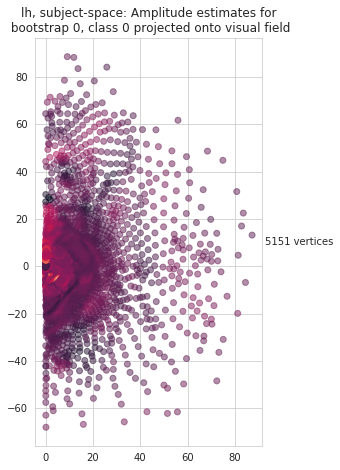

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5), subplot_kw={'aspect': 1})
ax.scatter(x, y, c=submesh.properties['models_bootstrap_00'][:,2], alpha=.5)
ax.set_title('lh, subject-space: Amplitude estimates for\n bootstrap 0, class 0 projected onto visual field')
ax.text(1.01, .5, f"{x.shape[0]} vertices", transform=ax.transAxes, va='center')

Add the x, y coordinates to the submesh

In [110]:
submesh = submesh.copy(coordinates=[x, y])

Interpolate `modelmd`, the median beta weights, to the fsaverage x and y

In [121]:
interp_modelmd = submesh.interpolate([prior_x, prior_y], 'models_bootstrap_01', method='linear')

Finally, let's see what this looks like. It looks similar to the earlier plot, but sampled at different locations

(3701,)


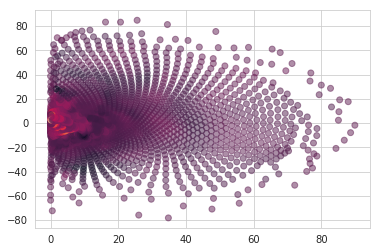

In [14]:
print(prior_x.shape)
plt.scatter(prior_x, prior_y, c=interp_modelmd[:, 2], alpha=.5)

Next steps:
- Want to recreate the output of GLMdenoise, which we can then feed into first_level_analysis
 - do this for every subject, and dump the outputs somewhere (as arrays is fine)
 - function then loads in all of those, does weighted average across subjects, and then creates an h5py file that has models, modelmd, and modelse (will need to compute that last one ourselves)
   - will need this to be the same shape as the full brain for fsaverage, so for each of these, create a `zeros_like(prior_varea)`, then up `np.where(varea==1)` and insert the values there
   - will also need to be in same shape as original:
     - models: (bootstraps, classes, 1, vertices, 1)
     - modelmd/modelse: (classes, 1, vertices, 1)
 - dump that out and then call first_level_analysis, with the correct `benson_template_path` and names and set `prf_data_names=[]` so it doesn't try and load them in (if that fails, should be trivial to fix)